# Adaptive Asset Allocation

This notebook implements various portfolio allocation strategies including:
- Equal Weight
- Volatility-Weighted
- Momentum Portfolio
- Combo (Momentum + Volatility)
- Adaptive Asset Allocation (AAA) using Minimum Variance

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

# Add helpers directory to path
#sys.path.append(str(Path.cwd() / 'aulas'))
#from helpers import get_yahoo_data

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

## Load Historical Data

Download historical price data from Yahoo Finance for the following assets:
- SPY: S&P 500 ETF
- EFA: EAFE ETF
- EWJ: Japan ETF
- EEM: Emerging Markets ETF
- IYR: US Real Estate ETF
- RWX: International Real Estate ETF
- IEF: 7-10 Year Treasury Bond ETF
- TLT: 20+ Year Treasury Bond ETF
- DBC: Commodities ETF
- GLD: Gold ETF

In [2]:
# Define tickers
tickers = ['SPY', 'EFA', 'EWJ', 'EEM', 'IYR', 'RWX', 'IEF', 'TLT', 'DBC', 'GLD']
start_date='1980-01-01'
end_date='2025-12-31'
interval='1d'

# Download data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date, interval=interval, group_by='ticker', auto_adjust=False, threads=True)

print(f"Data downloaded successfully")
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Shape: {data.shape}")

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed


Data downloaded successfully
Date range: 1993-01-29 00:00:00 to 2025-10-17 00:00:00
Shape: (8237, 60)


## Prepare Data

Extract adjusted close prices and filter data from December 2004 onwards

In [3]:
# Extract adjusted close prices
if isinstance(data.columns, pd.MultiIndex):
    # If multi-indexed (multiple tickers)
    prices = data.xs('Adj Close', level=1, axis=1)
else:
    # Single ticker
    prices = data[['Adj Close']].copy()
    prices.columns = tickers

# Filter data from December 2004 onwards
prices = prices.loc['2004-12':]

# Remove any rows with all NaN values
prices = prices.dropna(how='all')

# Forward fill missing values to align data
prices = prices.fillna(method='ffill')

print(f"Prices shape: {prices.shape}")
print(f"Date range: {prices.index.min()} to {prices.index.max()}")
print(f"\nFirst few rows:")
print(prices.head())

Prices shape: (5254, 10)
Date range: 2004-12-01 00:00:00 to 2025-10-17 00:00:00

First few rows:
Ticker      DBC        EEM        IYR        SPY        IEF        EWJ  RWX  \
Date                                                                          
2004-12-01  NaN  14.358909  27.887543  80.737762  48.486004  30.663918  NaN   
2004-12-02  NaN  14.337727  27.633512  80.805458  48.376598  30.781296  NaN   
2004-12-03  NaN  14.402746  28.113861  80.751297  48.860291  30.869339  NaN   
2004-12-06  NaN  14.382292  28.243164  80.724205  48.952400  30.546551  NaN   
2004-12-07  NaN  14.161664  27.855207  79.972549  48.946617  30.047707  NaN   

Ticker            GLD        TLT        EFA  
Date                                         
2004-12-01  45.380001  44.215763  28.820555  
2004-12-02  44.950001  44.036755  28.774944  
2004-12-03  45.599998  44.722126  28.946459  
2004-12-06  45.169998  44.875572  28.769472  
2004-12-07  45.110001  44.931816  28.612556  


## Define Parameters and Helper Functions

In [4]:
# Strategy parameters
n_top = 5           # number of momentum positions
n_mom = 6 * 22      # length of momentum look back (6 months)
n_vol = 1 * 22      # length of volatility look back (1 month)

# Get period ends (monthly rebalancing)
period_ends = prices.resample('M').last().index
period_ends = prices.index[prices.index.isin(period_ends)]

print(f"Number of rebalancing periods: {len(period_ends)}")
print(f"First rebalancing date: {period_ends[0]}")
print(f"Last rebalancing date: {period_ends[-1]}")

Number of rebalancing periods: 178
First rebalancing date: 2004-12-31 00:00:00
Last rebalancing date: 2025-09-30 00:00:00


In [5]:
# Helper functions

def ntop(data, n):
    """
    Select top n assets based on values (e.g., momentum).
    Returns a binary weight matrix (1 for top n, 0 otherwise).
    Equal weight is assigned to top n assets.
    """
    weights = pd.DataFrame(0.0, index=data.index, columns=data.columns)
    
    for date in data.index:
        values = data.loc[date].dropna()
        if len(values) > 0:
            # Get top n assets
            top_assets = values.nlargest(min(n, len(values))).index
            weights.loc[date, top_assets] = 1.0 / len(top_assets)
    
    return weights


def calculate_returns(prices, weights):
    """
    Calculate portfolio returns given prices and weights.
    Weights are assumed to be set at rebalancing dates and held until next rebalancing.
    """
    # Calculate daily returns
    returns = prices.pct_change()
    
    # Forward fill weights to get daily positions
    daily_weights = weights.reindex(prices.index).fillna(method='ffill')
    
    # Calculate portfolio returns
    portfolio_returns = (returns * daily_weights).sum(axis=1)
    
    return portfolio_returns


def min_variance_portfolio(returns_data):
    """
    Calculate minimum variance portfolio weights.
    
    Parameters:
    returns_data: DataFrame of historical returns
    
    Returns:
    weights: array of optimal weights
    """
    n_assets = returns_data.shape[1]
    
    # Calculate covariance matrix
    cov_matrix = returns_data.cov().values
    
    # Objective function: portfolio variance
    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights
    
    # Constraints: weights sum to 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    
    # Bounds: 0 <= weight <= 1
    bounds = tuple((0, 1) for _ in range(n_assets))
    
    # Initial guess: equal weights
    initial_weights = np.array([1.0 / n_assets] * n_assets)
    
    # Optimize
    result = minimize(
        portfolio_variance,
        initial_weights,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result.x if result.success else initial_weights


def backtest_strategy(prices, weights, strategy_name='Strategy'):
    """
    Backtest a strategy and return performance metrics.
    """
    returns = calculate_returns(prices, weights)
    
    # Calculate cumulative returns
    cumulative_returns = (1 + returns).cumprod()
    
    # Performance metrics
    total_return = cumulative_returns.iloc[-1] - 1
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    annualized_vol = returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_vol if annualized_vol > 0 else 0
    
    # Maximum drawdown
    running_max = cumulative_returns.expanding().max()
    drawdown = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdown.min()
    
    results = {
        'strategy': strategy_name,
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_vol,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'returns': returns,
        'cumulative_returns': cumulative_returns
    }
    
    return results

print("Helper functions defined successfully")

Helper functions defined successfully


## Strategy 1: Equal Weight Portfolio

Allocate equal weight to all assets in the universe.

In [6]:
# Equal weight strategy
n = prices.shape[1]
weights_equal = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)

for date in period_ends:
    available_assets = prices.loc[date].notna()
    n_available = available_assets.sum()
    if n_available > 0:
        weights_equal.loc[date, available_assets] = 1.0 / n_available

# Backtest
results_equal = backtest_strategy(prices, weights_equal, 'Equal Weight')

print(f"Equal Weight Strategy Results:")
print(f"Total Return: {results_equal['total_return']:.2%}")
print(f"Annualized Return: {results_equal['annualized_return']:.2%}")
print(f"Annualized Volatility: {results_equal['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {results_equal['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {results_equal['max_drawdown']:.2%}")

Equal Weight Strategy Results:
Total Return: 5.15%
Annualized Return: 0.24%
Annualized Volatility: 1.99%
Sharpe Ratio: 0.12
Max Drawdown: -11.93%


## Strategy 2: Volatility-Weighted Portfolio

Weight assets inversely proportional to their historical volatility.

In [7]:
# Calculate log returns
ret_log = np.log(prices / prices.shift(1))

# Calculate rolling volatility
hist_vol = ret_log.rolling(window=n_vol, min_periods=n_vol).std()

# Volatility-weighted strategy
weights_vol = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)

for date in period_ends:
    if date in hist_vol.index:
        vol_values = hist_vol.loc[date].dropna()
        if len(vol_values) > 0 and (vol_values > 0).all():
            # Inverse volatility weighting
            inv_vol = 1.0 / vol_values
            weights_vol.loc[date] = inv_vol / inv_vol.sum()

# Backtest
results_vol = backtest_strategy(prices, weights_vol, 'Volatility Weighted')

print(f"Volatility-Weighted Strategy Results:")
print(f"Total Return: {results_vol['total_return']:.2%}")
print(f"Annualized Return: {results_vol['annualized_return']:.2%}")
print(f"Annualized Volatility: {results_vol['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {results_vol['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {results_vol['max_drawdown']:.2%}")

Volatility-Weighted Strategy Results:
Total Return: 2.87%
Annualized Return: 0.14%
Annualized Volatility: 1.51%
Sharpe Ratio: 0.09
Max Drawdown: -9.73%


## Strategy 3: Momentum Portfolio

Select top N assets based on momentum (6-month price performance) and weight them equally.

In [8]:
# Calculate momentum (price relative to n_mom days ago)
momentum = prices / prices.shift(n_mom)

# Momentum strategy: select top n_top assets
weights_momentum = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)

for date in period_ends:
    if date in momentum.index:
        mom_values = momentum.loc[date].dropna()
        if len(mom_values) > 0:
            top_assets = mom_values.nlargest(min(n_top, len(mom_values))).index
            weights_momentum.loc[date, top_assets] = 1.0 / len(top_assets)

# Backtest
results_momentum = backtest_strategy(prices, weights_momentum, 'Momentum')

print(f"Momentum Strategy Results:")
print(f"Total Return: {results_momentum['total_return']:.2%}")
print(f"Annualized Return: {results_momentum['annualized_return']:.2%}")
print(f"Annualized Volatility: {results_momentum['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {results_momentum['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {results_momentum['max_drawdown']:.2%}")

Momentum Strategy Results:
Total Return: -0.37%
Annualized Return: -0.02%
Annualized Volatility: 1.99%
Sharpe Ratio: -0.01
Max Drawdown: -12.93%


## Strategy 4: Combo (Momentum + Volatility)

Select top momentum assets and weight them by inverse volatility.

In [9]:
# Combo strategy: momentum selection + volatility weighting
weights_combo = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)

for date in period_ends:
    if date in momentum.index and date in hist_vol.index:
        # Select top momentum assets
        mom_values = momentum.loc[date].dropna()
        if len(mom_values) > 0:
            top_assets = mom_values.nlargest(min(n_top, len(mom_values))).index
            
            # Get volatility for top assets
            vol_values = hist_vol.loc[date, top_assets].dropna()
            if len(vol_values) > 0 and (vol_values > 0).all():
                # Inverse volatility weighting
                inv_vol = 1.0 / vol_values
                weights_combo.loc[date, vol_values.index] = inv_vol / inv_vol.sum()

# Backtest
results_combo = backtest_strategy(prices, weights_combo, 'Combo (Momentum + Volatility)')

print(f"Combo Strategy Results:")
print(f"Total Return: {results_combo['total_return']:.2%}")
print(f"Annualized Return: {results_combo['annualized_return']:.2%}")
print(f"Annualized Volatility: {results_combo['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {results_combo['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {results_combo['max_drawdown']:.2%}")

Combo Strategy Results:
Total Return: 1.40%
Annualized Return: 0.07%
Annualized Volatility: 1.79%
Sharpe Ratio: 0.04
Max Drawdown: -10.59%


## Strategy 5: Adaptive Asset Allocation (AAA)

Select top momentum assets and weight them using minimum variance optimization.

In [10]:
# Adaptive Asset Allocation (AAA)
weights_aaa = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)

# Filter period ends to ensure we have enough historical data
valid_period_ends = [date for date in period_ends if prices.index.get_loc(date) >= n_mom]

for date in valid_period_ends:
    if date not in momentum.index:
        continue
    
    # Select top momentum assets
    mom_values = momentum.loc[date].dropna()
    if len(mom_values) == 0:
        continue
    
    top_assets = mom_values.nlargest(min(n_top, len(mom_values))).index.tolist()
    
    # Get historical returns for selected assets
    date_idx = prices.index.get_loc(date)
    start_idx = max(0, date_idx - n_vol + 1)
    hist_returns = ret_log.iloc[start_idx:date_idx + 1][top_assets]
    
    # Require all assets to have full price history
    complete_assets = hist_returns.columns[hist_returns.notna().sum() == n_vol].tolist()
    
    if len(complete_assets) > 0:
        hist_returns_complete = hist_returns[complete_assets].dropna()
        
        if len(hist_returns_complete) >= n_vol:
            # Calculate minimum variance weights
            opt_weights = min_variance_portfolio(hist_returns_complete)
            weights_aaa.loc[date, complete_assets] = opt_weights

# Backtest
results_aaa = backtest_strategy(prices, weights_aaa, 'Adaptive Asset Allocation (AAA)')

print(f"Adaptive Asset Allocation (AAA) Strategy Results:")
print(f"Total Return: {results_aaa['total_return']:.2%}")
print(f"Annualized Return: {results_aaa['annualized_return']:.2%}")
print(f"Annualized Volatility: {results_aaa['annualized_volatility']:.2%}")
print(f"Sharpe Ratio: {results_aaa['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {results_aaa['max_drawdown']:.2%}")

Adaptive Asset Allocation (AAA) Strategy Results:
Total Return: -0.54%
Annualized Return: -0.03%
Annualized Volatility: 1.99%
Sharpe Ratio: -0.01
Max Drawdown: -12.72%


## Compare All Strategies

In [11]:
# Create summary table
all_results = [results_equal, results_vol, results_momentum, results_combo, results_aaa]

summary_data = []
for result in all_results:
    summary_data.append({
        'Strategy': result['strategy'],
        'Total Return': f"{result['total_return']:.2%}",
        'Annualized Return': f"{result['annualized_return']:.2%}",
        'Annualized Volatility': f"{result['annualized_volatility']:.2%}",
        'Sharpe Ratio': f"{result['sharpe_ratio']:.2f}",
        'Max Drawdown': f"{result['max_drawdown']:.2%}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*100)
print("STRATEGY COMPARISON SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)


STRATEGY COMPARISON SUMMARY
                       Strategy Total Return Annualized Return Annualized Volatility Sharpe Ratio Max Drawdown
                   Equal Weight        5.15%             0.24%                 1.99%         0.12      -11.93%
            Volatility Weighted        2.87%             0.14%                 1.51%         0.09       -9.73%
                       Momentum       -0.37%            -0.02%                 1.99%        -0.01      -12.93%
  Combo (Momentum + Volatility)        1.40%             0.07%                 1.79%         0.04      -10.59%
Adaptive Asset Allocation (AAA)       -0.54%            -0.03%                 1.99%        -0.01      -12.72%


## Visualize Performance

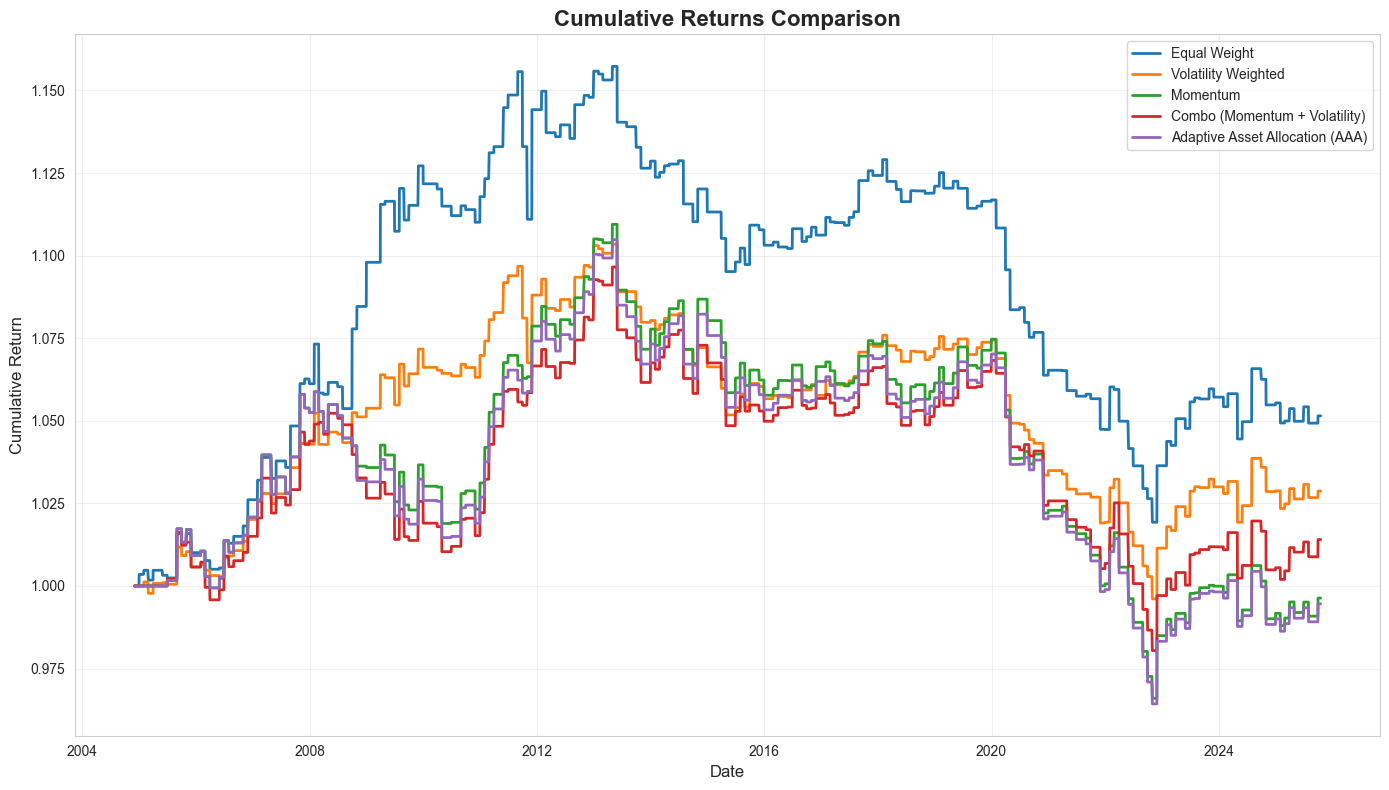

In [12]:
# Plot cumulative returns
plt.figure(figsize=(14, 8))

for result in all_results:
    plt.plot(result['cumulative_returns'], label=result['strategy'], linewidth=2)

plt.title('Cumulative Returns Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

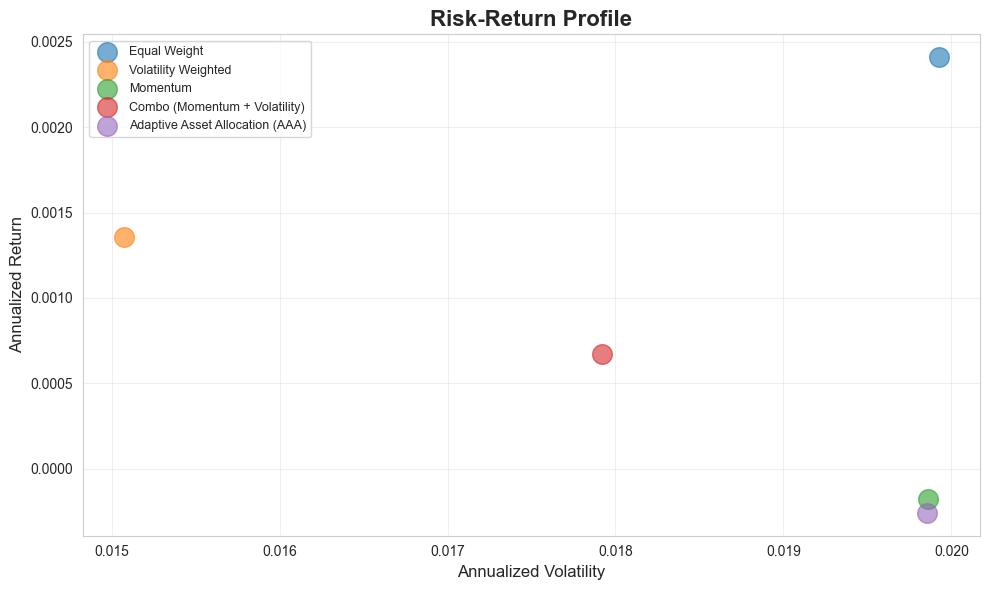

In [13]:
# Plot risk-return scatter
plt.figure(figsize=(10, 6))

for result in all_results:
    plt.scatter(
        result['annualized_volatility'],
        result['annualized_return'],
        s=200,
        alpha=0.6,
        label=result['strategy']
    )

plt.title('Risk-Return Profile', fontsize=16, fontweight='bold')
plt.xlabel('Annualized Volatility', fontsize=12)
plt.ylabel('Annualized Return', fontsize=12)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

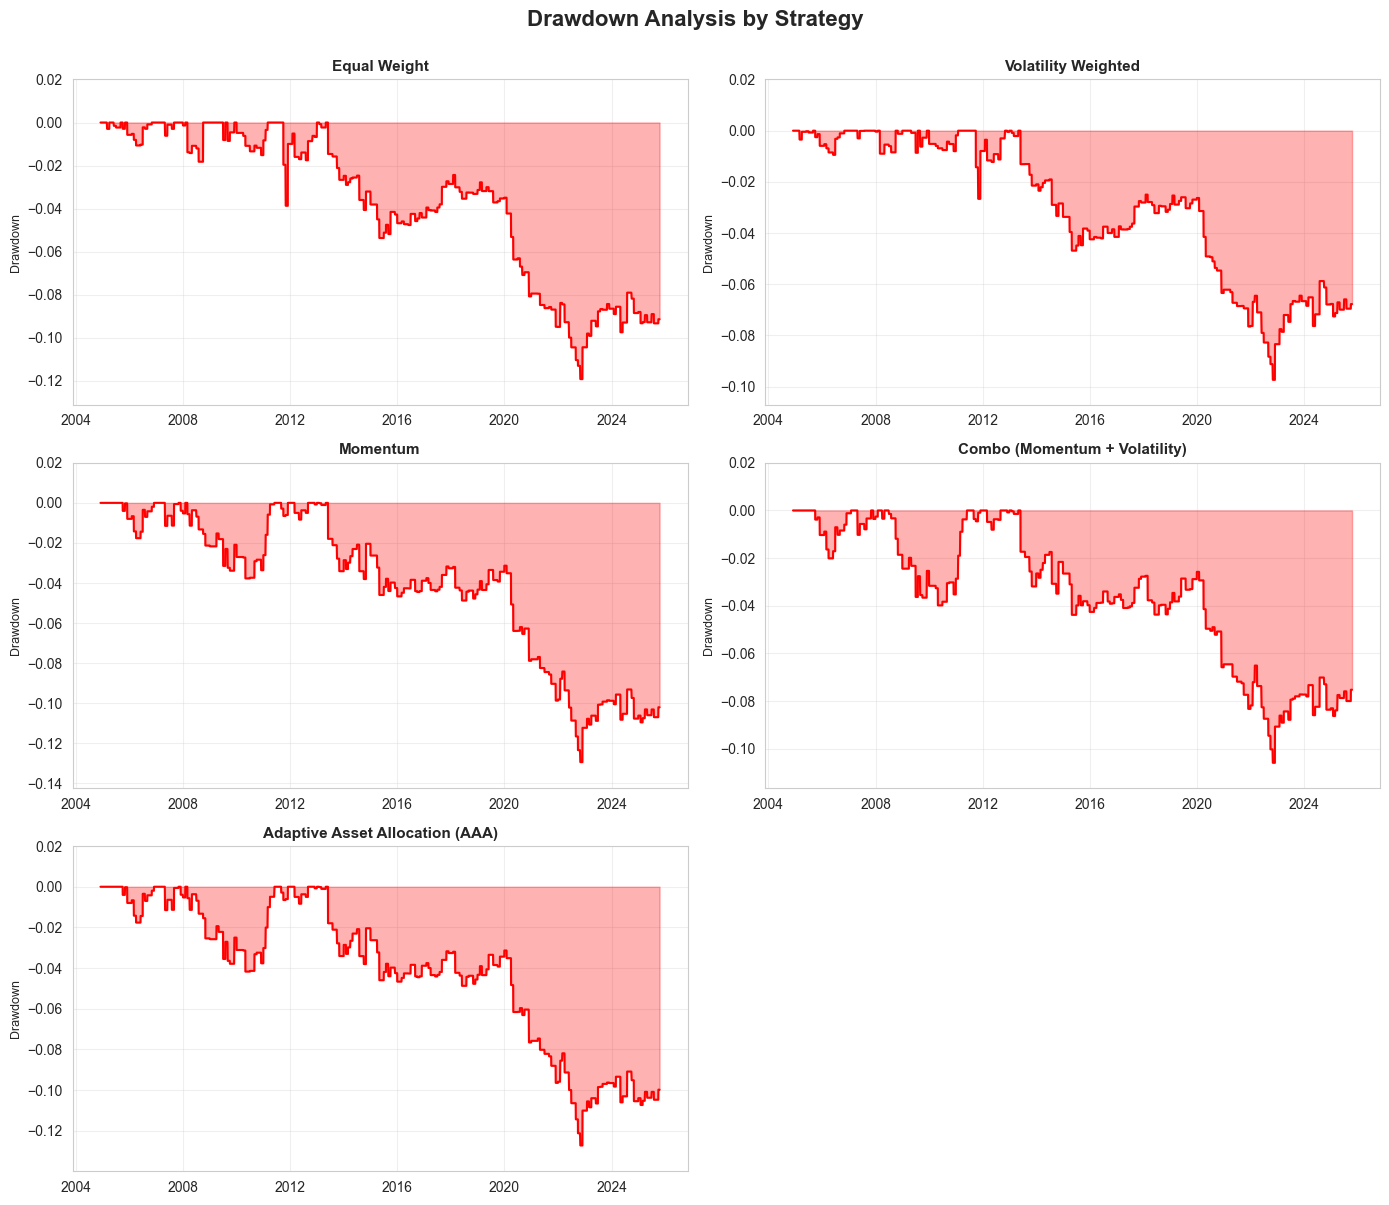

In [14]:
# Plot drawdowns
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, result in enumerate(all_results):
    cumulative = result['cumulative_returns']
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    
    axes[idx].fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
    axes[idx].plot(drawdown, color='red', linewidth=1.5)
    axes[idx].set_title(result['strategy'], fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Drawdown', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim([drawdown.min() * 1.1, 0.02])

# Hide the last subplot if we have an odd number of strategies
if len(all_results) < 6:
    axes[-1].axis('off')

plt.suptitle('Drawdown Analysis by Strategy', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Save Results

In [ ]:
# Save summary to CSV
summary_df.to_csv('adaptive_asset_allocation_results.csv', index=False)
print("Results saved to 'adaptive_asset_allocation_results.csv'")

# Save cumulative returns for all strategies
cumulative_returns_df = pd.DataFrame({
    result['strategy']: result['cumulative_returns'] for result in all_results
})
cumulative_returns_df.to_csv('adaptive_asset_allocation_cumulative_returns.csv')
print("Cumulative returns saved to 'adaptive_asset_allocation_cumulative_returns.csv'")